

---

**IMPORTS**

---





In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Embedding, Activation, TimeDistributed



---
**READING DATA**


---




In [2]:
with open("/content/ABC_DATA.txt","r") as f:
    text=f.read()



---
**INITIALIZING MODEL**

---





In [3]:
ACCURACIES, LOSSES = [], []

class Model():
    def __init__(self, seq_len, b_size, c2ix, t_matrix):

        self.sequence_len = seq_len
        self.batch_size = b_size

        self.char2idx = c2ix
        self.idx2char = {v: k for k, v in self.char2idx.items()}
        self.voc_size = len(self.char2idx)

        self.T = t_matrix
        self.model = Sequential()
        self.model.add(Embedding(self.voc_size, 512, batch_input_shape=(self.batch_size, self.sequence_len)))

        for _ in range(2):
            self.model.add(LSTM(512, return_sequences=True, stateful=True))
            self.model.add(Dropout(0.25))

        self.model.add(TimeDistributed(Dense(self.voc_size)))
        self.model.add(Activation('softmax'))
        self.model.summary()
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.batches = self.generate_batches()

    def generate_batches(self):
        length = self.T.shape[0];
        char_batch = int(length / self.batch_size);
        res = []
        for start in range(0, char_batch - self.sequence_len, self.sequence_len):
            res.append(self.generate_batch(char_batch, start))
        return res

    def generate_batch(self, chars_batch, start):
        X = np.zeros((self.batch_size, self.sequence_len))
        Y = np.zeros((self.batch_size, self.sequence_len, self.voc_size))
        for b_idx in range(0, self.batch_size):
            for i in range(0, self.sequence_len):
                X[b_idx, i] = self.T[chars_batch * b_idx + start + i]
                Y[b_idx, i, self.T[chars_batch * b_idx + start + i + 1]] = 1
        return X, Y

    def train(self, epochs):
        for epoch in range(epochs):
            print('\nEpochs: {}/{}\n'.format(epoch + 1, epochs))
            for i, (X, Y) in enumerate(self.batches):
                loss, acc = self.model.train_on_batch(X, Y)
                print('batch # {} => acc = {}, loss = {}'.format(i, acc, loss))
                if i == 14:
                  ACCURACIES.append(acc)
                  LOSSES.append(loss)



---
**TRAINING**


---





In [4]:
seq_length = 32
batch_size = 256
epochs = 120

char_to_idx = {ch: i for i, ch in enumerate(sorted(list(set(text))))}
t_matrix = np.asarray([char_to_idx[c] for c in text], dtype=np.int32)

m = Model(seq_length, batch_size, char_to_idx, t_matrix)
m.train(epochs)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (256, 32, 512)            44032     
_________________________________________________________________
lstm (LSTM)                  (256, 32, 512)            2099200   
_________________________________________________________________
dropout (Dropout)            (256, 32, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (256, 32, 512)            2099200   
_________________________________________________________________
dropout_1 (Dropout)          (256, 32, 512)            0         
_________________________________________________________________
time_distributed (TimeDistri (256, 32, 86)             44118     
_________________________________________________________________
activation (Activation)      (256, 32, 86)             0



---
**PLOTS**

---





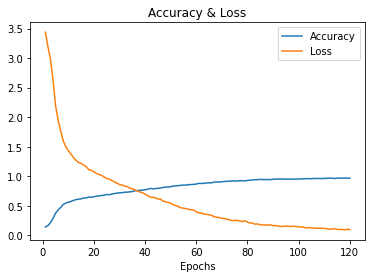

In [12]:
plt.figure()
plt.title('Accuracy & Loss')
plt.xlabel('Epochs')
plt.plot([x for x in range(1, epochs+1)], ACCURACIES, label = "Accuracy")
plt.plot([x for x in range(1, epochs+1)], LOSSES, label = "Loss")
plt.legend()
plt.show()